In [15]:
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import statistics as stat

import tifffile as tif

# Background Estimation

In [68]:
filename = "video2.avi"
location = "//storage.ncbs.res.in/harshavardanbn/data/210331/F3/"
length = 10000

count = 0
random = np.random.randint(300, length, 50)

bg_frames = [] #stores frames to used for bg calculation

cap = cv2.VideoCapture(location + filename)

while cap.isOpened:
    
    ret,frame = cap.read()
    
    if ret == 0:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if count == length:
        break
        
    if count in random:
        copy = frame.copy()
        bg_frames.append(copy)
    
    cv2.imshow("frame", frame)  
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    count += 1
    
cap.release()
cv2.destroyAllWindows()

bg_frames = np.array(bg_frames)
bg = np.median(bg_frames, axis = 0)
bg = cv2.convertScaleAbs(bg)
cv2.imshow('Background', bg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#tif.imsave(location+filename.split('.avi')[0]+'.tif',bg)

# Motion Detection

In [86]:
cap = cv2.VideoCapture(location + filename)

count = 0
random = np.random.randint(0, 500, 25)

bg_frames = [] #stores frames to used for bg calculation
x_coor = []
y_coor = []

while cap.isOpened:
    
    ret,frame = cap.read()
    
    if ret == 0:
        break
    if count == 1201:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur_kernel = (10, 10)
    blur = cv2.blur(frame, blur_kernel)
    fg = frame - bg#blur - cv2.blur(bg, blur_kernel)
    _, thresh = cv2.threshold(fg, 100, 255, cv2.THRESH_BINARY)
    
    
    kernel = np.ones((4, 4),np.uint8)
    erode = cv2.erode(thresh, kernel, iterations = 1)
    kernel = np.ones((5, 5),np.uint8)
    dilate = cv2.dilate(erode, kernel, iterations = 5)
    
    _, contours, _ = cv2.findContours(erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest = max(contours, key = cv2.contourArea)
    
    (x,y),radius = cv2.minEnclosingCircle(largest)
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(frame, center, 5, 5)
    x_coor.append(int(x))
    y_coor.append(int(y))
    
#     for i in range(len(x_coor) - 1):
#         cv2.circle(frame, (x_coor[i], y_coor[i]), 2, -1)

    roi = frame[int(y) - 100: int(y) + 100, int(x) - 100: int(x) + 100].copy()
    
    cv2.imshow("frame", roi) 
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    count += 1
    
cap.release()
cv2.destroyAllWindows()

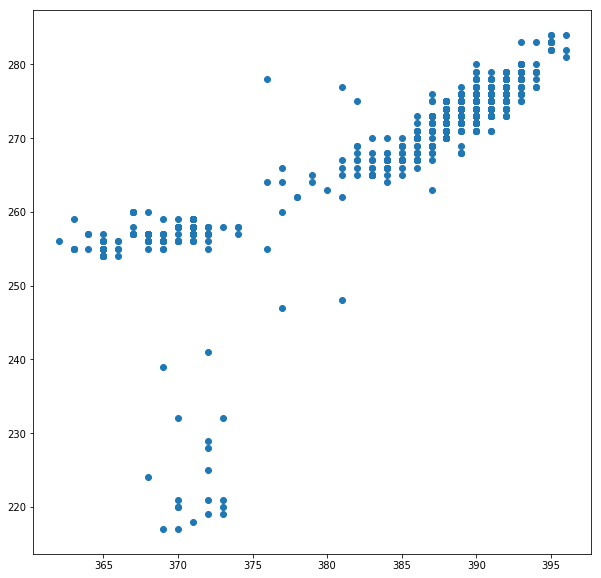

In [70]:
plt.figure(figsize = (10, 10))
plt.scatter(x_coor, y_coor)

output = [x_coor, y_coor]
fields = ["x","y"]

with open(location + filename[:-4] + "coordinates.csv", "w") as csv_file:
    csvwriter = csv.writer(csv_file)
    csvwriter.writerow(fields)
    for i in range(len(output[0])):
        csvwriter.writerow([output[0][i], output[1][i]])

In [71]:
dist = []
vel = []

for i in range(len(x_coor) - 1):
    distance = ((x_coor[i + 1] - x_coor[i])**2 + (y_coor[i + 1] - y_coor[i])**2)**0.5
    if distance <= 5:
        dist.append(0)
    else:
        dist.append(distance)
    #if i != 0:
        #dist[-1] += dist[-2]

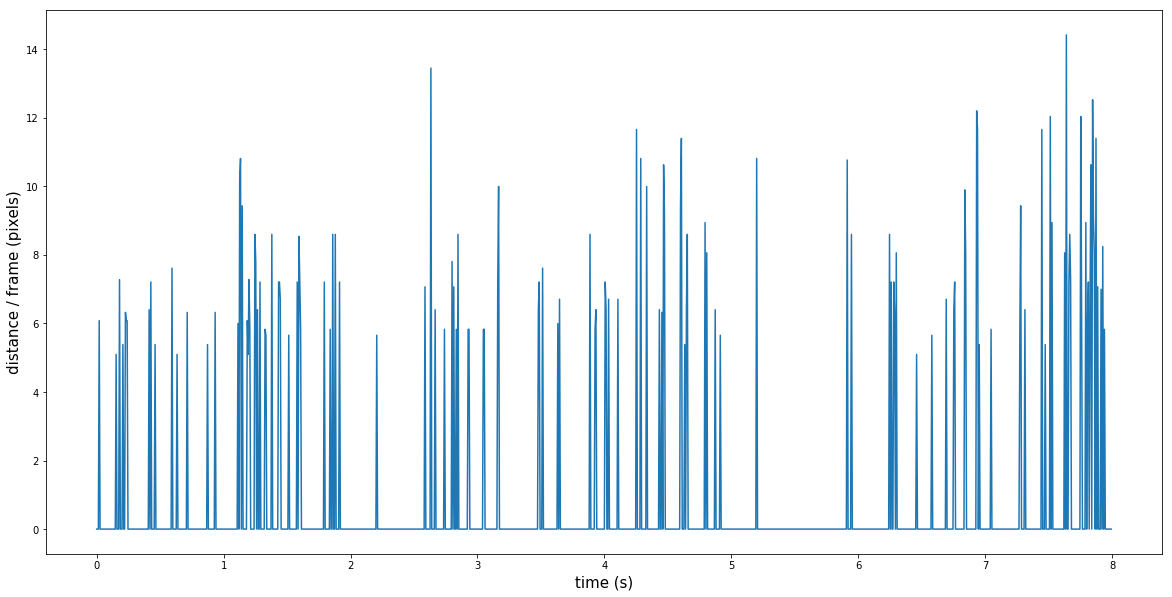

In [72]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(0, 8, 0.0066667), dist[:1200])
plt.xlabel("time (s)", fontsize = 15)
plt.ylabel("distance / frame (pixels)", fontsize = 15)
plt.savefig("./dist_time_plot.png")

In [35]:
x_coor = []
y_coor = []
cap = cv2.VideoCapture(location + filename)
while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.convertScaleAbs(frame * 1.75)
    corners = cv2.goodFeaturesToTrack(frame, 2, 0.5, 5)
    x_avg = 0
    y_avg = 0
    for i in corners:
        x, y = i.ravel()
        x_avg += x
        y_avg += y
        #cv2.circle(frame, (x, y), 1, 255, -1)
        #cv2.imshow("corners", frame)
    cv2.circle(frame, (int(x_avg/2), int(y_avg/2)), 1, 255, -1)
    cv2.imshow("fish", frame)
    x_coor.append(int(x_avg/2))
    y_coor.append(int(y_avg/2))
        
    if cv2.waitKey(1) & 0xff == ord("q"):
            break
cap.release()
cv2.destroyAllWindows()

In [73]:
len(dist)

1200

In [ ]:
cv2.imshow("frame", cv2.convertScaleAbs((copy - bg) * 0.5))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [34]:
import cv2
filename = "video2.avi"
location = "//storage.ncbs.res.in/harshavardanbn/data/210331/F3/"
backSub1 = cv2.createBackgroundSubtractorMOG2()
backSub2 = cv2.createBackgroundSubtractorKNN()
#backSub3 = cv2.createBackgroundSubtractorCNT()

cap = cv2.VideoCapture(location + filename)

while True:
    ret, frame = cap.read()
    if frame is None:
        break
    
    fgMask = backSub1.apply(frame)
    
    
    cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
               cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    
    #cv2.imshow('Frame', frame)
    cv2.imshow('FG Mask', fgMask)
    
    if cv2.waitKey(1) & 0xff == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

In [14]:
backgroundImage=cv2.BackgroundSubtractor.getBackgroundImage([backgroundImage])

NameError: name 'backgroundImage' is not defined

In [54]:
c = cv2.VideoCapture(location + filename)
_,f = c.read()

avg1 = np.float32(f)
avg2 = np.float32(f)

while(1):
    _,f = c.read()
    f = cv2.blur(f, (5, 5))
    f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)

    #cv2.accumulateWeighted(f,avg1,0.1)
    #cv2.accumulateWeighted(f,avg2,0.01)

    #res1 = cv2.convertScaleAbs(avg1)
    #res2 = cv2.convertScaleAbs(avg2)

    #cv2.imshow('img',f)
    cv2.imshow('avg1',cv2.convertScaleAbs(f - cv2.blur(bg, (5, 5))))
    #cv2.imshow('avg2',res2)

    if cv2.waitKey(1) & 0xff == ord("q"):
        break

cv2.destroyAllWindows()
c.release()

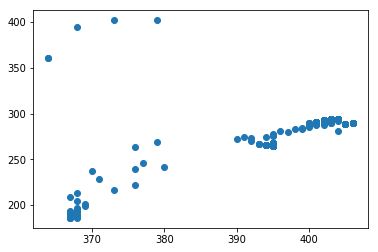

In [37]:
plt.scatter(x_coor, y_coor)

In [41]:
dist = []
vel = []

for i in range(len(x_coor) - 1):
    distance = ((x_coor[i + 1] - x_coor[i])**2 + (y_coor[i + 1] - y_coor[i])**2)**0.5
    if distance <= 0:
        dist.append(0)
    else:
        dist.append(distance)
    #if i != 0:
        #dist[-1] += dist[-2]

(0, 10)

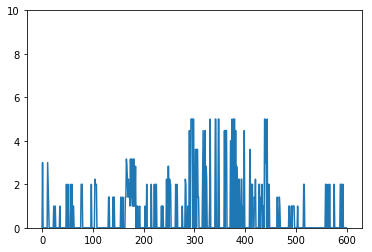

In [46]:
plt.plot(dist[:600])
plt.ylim(0, 10)